In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from skimage import filters
from skimage import feature
from skimage.filters import prewitt_h,prewitt_v
from skimage.io import imread, imshow
import torch
import imghdr
import nltk
from nltk.tokenize import word_tokenize
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot, make_dot_from_trace
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-djs8awd2
  Running command git clone -q https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-djs8awd2
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
parent=r''


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Image Preprocessing

In [ ]:
os.chdir(parent)
os.rename('image_960.jpe','image_960.jpg')
os.rename('image_1615.PNG','image_1615.png')
os.rename('image_1795.JPG','image_1795.jpg')
os.rename('image_1803.JPG','image_1803.jpg')
os.rename('image_1804.JPG','image_1804.jpg')
os.remove('image_5119.png')


In [ ]:
def image_names():
    image_names=[]
    os.chdir(parent+'\images')
    for i in os.listdir():
        image1=imread(i)
        if image1.shape[0]<2250 and image1.shape[1]<2250:
            image_names.append(i)
    return image_names

In [ ]:
image_name= image_names()


In [ ]:
for i in os.listdir():
    if i not in image_name:
        os.remove(i)

In [ ]:
def resized_images(new_path):
    for i in image_name:
        os.chdir(parent+'\images')
        temp = Image.open(i)
        temp= temp.convert('L')
        temp = temp.resize((350,390))
        os.chdir(new_path)
        temp.save(i)
        

In [ ]:
new_path=parent+"\Copy\Resized"
resized_images(new_path)

In [ ]:
def featured_images(featured_path):
    for i in image_name:
        os.chdir(new_path)
        img = Image.open(i)
        pre_hor = prewitt_h(img)
        pre_ver = prewitt_v(img)
        previt=pre_hor+pre_ver
        os.chdir(featured_path)
        plt.imsave(i,previt,cmap='gray')


In [3]:
featured_path="/content/drive/MyDrive/FeaturedImages"
featured_images(featured_path)

In [ ]:
label_path=r""
os.chdir(label_path)
df=pd.read_excel('labels.xlsx')
df=df.drop(labels="Unnamed: 0",axis=1)


In [ ]:
removed=[]
images=list(np.array(df['image_name']))
for i in images:
    if i not in image_name:
        removed.append(i)
list1=[ 'image_960.jpe','image_1615.PNG','image_1795.JPG','image_1803.JPG','image_1804.JPG']
for i in list1:
    removed.remove(i)

for i in removed:
    df.drop(df.index[df['image_name'] == i],axis=0,inplace=True)

df.loc[df['overall_sentiment'] =='very_positive' , 'overall_sentiment'] = 0
df.loc[df['overall_sentiment'] =='positive' , 'overall_sentiment'] = 0
df.loc[df['overall_sentiment'] =='negative' , 'overall_sentiment'] = 1
df.loc[df['overall_sentiment'] =='very_negative' , 'overall_sentiment'] = 1
df.loc[df['overall_sentiment'] =='neutral' , 'overall_sentiment'] = 2

df

,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,0
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,0
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,0
3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,0
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,2
...,...,...,...,...,...,...,...,...
6987,image_6988.jpg,Tuesday is Mardi Gras Wednesday is Valentine's...,Tuesday is Mardi Gras Wednesday is Valentine's...,very_funny,twisted_meaning,very_offensive,motivational,2
6988,image_6989.jpg,MUST WATCH MOVIES OF 2017 ITI Chennai memes MA...,MUST WATCH MOVIES OF 2017 ITI Chennai memes MA...,funny,twisted_meaning,not_offensive,not_motivational,2
6989,image_6990.png,LESS MORE TALKING PLANNING SODA JUNK FOOD COMP...,LESS MORE TALKING PLANNING SODA JUNK FOOD COMP...,funny,general,slight,not_motivational,0
6990,image_6991.jpg,When I VERY have time is a fantasy No one has ...,When I have time is a fantasy. no one has time...,not_funny,twisted_meaning,not_offensive,motivational,0


# Data Augmentation

In [ ]:
neutral_names=list(df[df['overall_sentiment']==2]['image_name'])
x=(df['overall_sentiment']==1)
negative_img=df[x]['image_name']

In [ ]:
def Neutral_Images_DataAugmentatation(featured_path):
    os.chdir(featured_path)
    for i in neutral_names:
        image=Image.open(i)
        x=imghdr.what(i)
        rotated = image.rotate(180)
        i=i.replace('.png','').replace('.jpeg','').replace('.jpg','').replace('.bmp','').replace('.JPG','')
        i +="_rotated"
        name=i+'.'+x
        os.chdir(featured_path)
        rotated.save(name)


In [ ]:
Neutral_Images_DataAugmentatation(featured_path)

In [ ]:
def Negative_Images_FlipTB(featured_path):
    os.chdir(featured_path)
    for i in negative_img:
        image=Image.open(i)
        x=imghdr.what(i)
        flip=image.transpose(Image.FLIP_TOP_BOTTOM)
        i=i.replace('.png','').replace('.jpeg','').replace('.jpg','').replace('.bmp','').replace('.JPG','')
        i +="_flipTB"
        name=i+'.'+x
        flip.save(name)


In [ ]:
def rotate(featured_path,degree):
    os.chdir(featured_path)
    for i in negative_img:
        image=Image.open(i)
        x=imghdr.what(i)
        rotated = image.rotate(degree,expand=True)
        i=i.replace('.png','').replace('.jpeg','').replace('.jpg','').replace('.bmp','').replace('.JPG','')
        if degree==180:
            i +="_rotated180"
        elif degree==90:
            i +="_rotated90"
        else:
            i +="_rotated270"
        name=i+'.'+x
        os.chdir(featured_path)
        rotated.save(name)


In [ ]:
def Negative_Images_Rotate(featured_path):
    rotate(featured_path,180)
    rotate(featured_path,90)
    rotate(featured_path,270)


In [ ]:
def Negative_Images_FlipLR(featured_path):
    os.chdir(featured_path)
    for i in negative_img:
        image=Image.open(i)
        x=imghdr.what(i)
        flip=image.transpose(Image.FLIP_LEFT_RIGHT)
        i=i.replace('.png','').replace('.jpeg','').replace('.jpg','').replace('.bmp','').replace('.JPG','')
        i +="_flipLR"
        name=i+'.'+x
        flip.save(name)


In [ ]:
def Negative_Images_Rotated180_FlipLR(featured_path):
    os.chdir(featured_path)
    for i in negative_img:
        x=imghdr.what(i)
        i=i.replace('.png','').replace('.jpeg','').replace('.jpg','').replace('.bmp','').replace('.JPG','')
        i +="_rotated180"
        name=i+'.'+x
        image=Image.open(name)
        flip=image.transpose(Image.FLIP_LEFT_RIGHT)
        i=i.replace('.png','').replace('.jpeg','').replace('.jpg','').replace('.bmp','').replace('.JPG','')
        i +="FLR"
        name=i+'.'+x
        flip.save(name)


In [ ]:
def Negative_Images_DataAugmentatation(featured_path):
    Negative_Images_FlipTB(featured_path)
    Negative_Images_FlipLR(featured_path)
    Negative_Images_Rotate(featured_path)
    Negative_Images_Rotated180_FlipLR(featured_path)

In [ ]:
Negative_Images_DataAugmentatation(featured_path)

# Glove 6B

In [4]:
glove_path="/content/drive/MyDrive/Glove_6B"
os.chdir(glove_path)

In [ ]:
Missing_text = ["CHALLENGE ACCEPTED! Friend: You can't honestly watch How I Met Your Mother again for like the 4th time.. Me:"
       ,"I'M GONNA BUILD SOME FANCY WALLS EVEN THOUGHIHAVE MILLIONS OF EXTRA DOLLARS IN GONNA MAKE THE MEXICANS PAY FORIT"
       ,"IF DONALD AND HILLARY ARE TOGETHER ON A BOAT IN THE MIDDLE OF THE OCEAN AND IT SINKS. WHO SURVIVES? AMERICA"
       ,"Bruh why this tub of margarine look like Donald Trump?"
       ,"2016 ELECTION TRUMPS HILIARY STILL'A BETTER LOVE STORY THAN TWILIGHT"]
x=df[df['text_corrected'].isna()]
nan_image_names=list(x['image_name'])
for i in range(0,len(nan_image_names)):
    df.loc[df['image_name'] ==nan_image_names[i] , 'text_corrected'] = Missing_text[i]
    

In [5]:
def glove_model(glove_path):
    glove_dict = {}
    with open(glove_path+'/'+'glove.6B.300d.txt','r',encoding="utf8") as f:
        for line in f:
            string = line.split()
            word = string[0]
            feature = np.array(string[1:], dtype=np.float64)
            glove_dict[word] = feature
    return glove_dict

In [6]:
glove=glove_model(glove_path)

# All Images DataFrame

In [ ]:
def append_Neutralrotatedimgs():
    temp=pd.DataFrame()
    for i in range(0,len(neutral_names)):
        temp=temp.append(df.loc[df['image_name'] == neutral_names[i]])

    os.chdir(featured_path)
    for j in neutral_names:
        x=imghdr.what(j)
        i=j
        i=i.replace('.png','').replace('.jpeg','').replace('.jpg','').replace('.bmp','').replace('.JPG','')
        i +="_rotated"
        name=i+'.'+x
        temp['image_name'].replace({j:name},inplace=True)
    return temp

In [ ]:
x=append_Neutralrotatedimgs()
df=pd.concat([df,x])

In [ ]:
temp=pd.DataFrame()
temp1=pd.DataFrame()
temp2=pd.DataFrame()
temp3=pd.DataFrame()
temp4=pd.DataFrame()
temp5=pd.DataFrame()

for i in negative_img:
        temp=temp.append(df.loc[df['image_name'] == i])
        temp1=temp1.append(df.loc[df['image_name'] == i])
        temp2=temp2.append(df.loc[df['image_name'] == i])
        temp3=temp3.append(df.loc[df['image_name'] == i])
        temp4=temp4.append(df.loc[df['image_name'] == i])
        temp5=temp5.append(df.loc[df['image_name'] == i])

In [ ]:
def append_Negativeimgs(string,df1):
    os.chdir(featured_path)
    names=np.array(df1['image_name'])
    for j in range(0,len(names)):
        img=names[j]
        x=imghdr.what(img)
        i=img
        i=i.replace('.png','').replace('.jpeg','').replace('.jpg','').replace('.bmp','').replace('.JPG','')
        i +="_"+string
        name=i+'.'+x
        df1['image_name'].replace({img:name},inplace=True)
        
    return df1

In [ ]:
df2=append_Negativeimgs("rotated90",temp)
df=pd.concat([df,df2])
df2=append_Negativeimgs("rotated180",temp1)
df=pd.concat([df,df2])
df2=append_Negativeimgs("rotated270",temp2)
df=pd.concat([df,df2])
df2=append_Negativeimgs("flipLR",temp3)
df=pd.concat([df,df2])
df2=append_Negativeimgs("flipTB",temp4)
df=pd.concat([df,df2])
df2=append_Negativeimgs("rotated180FLR",temp5)
df=pd.concat([df,df2])


In [ ]:
index=np.arange(0,12953)
df.set_index(index,inplace=True)
df.loc[df['image_name'] =='image_960.jpe' , 'image_name'] = 'image_960.jpg'

df

,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,0
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,0
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,0
3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,0
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,2
...,...,...,...,...,...,...,...,...
12948,image_6961_rotated180FLR.jpeg,THAT FACE YOUR FRIEND GIVES YOU WHEN YOUR CRUS...,THAT FACE YOUR FRIEND GIVES YOU WHEN YOUR CRUS...,very_funny,twisted_meaning,very_offensive,not_motivational,1
12949,image_6962_rotated180FLR.jpeg,NIGHTMARES Are made of this.,NIGHTMARES Are made of this.,not_funny,not_sarcastic,not_offensive,motivational,1
12950,image_6966_rotated180FLR.png,Baby Mr. Bean Funny Picture,Baby Mr. Bean Funny Picture,very_funny,twisted_meaning,very_offensive,not_motivational,1
12951,image_6972_rotated180FLR.jpeg,YOUR FACE MemeCenter.com WHEN THERES A SUBSTIT...,YOUR FACE MemeCenter.com WHEN THERES A SUBSTIT...,very_funny,general,very_offensive,not_motivational,1


In [ ]:
df.to_csv("ALL.csv")

# Features 

In [7]:
def image_features(img):
    image1 =imread(img,as_gray=True)
    feature =np.array(image1).flatten()
    label=df[df['image_name'] ==img]['overall_sentiment'].iloc[0]
    return feature,label


In [8]:
def text_features(img):
    feature=[]
    line=df[df['image_name'] ==img]['text_corrected'].iloc[0]
    text=line
    text=text.lower()
    words=word_tokenize(text)
    for j in words:
        try:
            feature.append(glove[j])
        except:
            pass
    feature=np.array(feature).flatten()
    maxi=62100
    feature=np.pad(feature,(0,maxi-len(feature)))
    return feature

# Train Test Split

In [29]:
os.chdir("/content/drive/MyDrive/Project_AI")
df=pd.read_csv('ALL.csv')
df=df.drop(labels="Unnamed: 0",axis=1)
df.loc[df['image_name'] =='image_1795.JPG' , 'image_name'] = 'image_1795.jpg'
df.loc[df['image_name'] =='image_1615.PNG' , 'image_name'] = 'image_1615.png'
df.loc[df['image_name'] =='image_1803.JPG' , 'image_name'] = 'image_1803.jpg'
df.loc[df['image_name'] =='image_1804.JPG' , 'image_name'] = 'image_1804.jpg'

train_df=df
train_df=train_df.drop(labels='overall_sentiment',axis=1)
X_train, X_test, y_train, y_test = train_test_split(train_df, df['overall_sentiment'], test_size=0.3, random_state=30,shuffle=True)


# Neural Network

In [10]:
class Multi_Model_NN(nn.Module):
    def __init__(self,textinput,inputneurons,textH1,textH2,comH1,ImageH1,ImageH2,output,ImageH3,textH3,ImageH4):
        super(Multi_Model_NN, self).__init__()
        
        self.text = nn.Sequential(
            nn.Linear(textinput, textH1),
            nn.ReLU(),
            nn.Linear(textH1, textH2),
            nn.ReLU(),
            nn.Linear(textH2, textH3)
       )
        self.image = nn.Sequential(
            nn.Linear(inputneurons,ImageH1),
            nn.Sigmoid(),
            nn.Linear(ImageH1, ImageH2),
            nn.Sigmoid(),
            nn.Linear(ImageH2, ImageH3),
            nn.ReLU(),
            nn.Linear(ImageH3, ImageH4)
        )
        
        self.combination_of_models = nn.Sequential(
            nn.Linear(textH3+ImageH4,comH1),
            nn.ReLU(),
            nn.Linear(comH1,output)
        )

    def forward(self,lines,img):
        t_output = self.text(lines)
        img_output = self.image(img)
        dual = torch.cat((t_output,img_output))
        x = self.combination_of_models(dual)
        return x

In [11]:
imginputneurons=350*390
imghidden1=1800
imghidden2=1200
imghidden3=700
imghidden4=400


textinput=62100
texthidden1=1500
texthidden2=800
texthidden3=500

comh1=500
output=3

neural_network=Multi_Model_NN(textinput,imginputneurons,texthidden1,texthidden2,comh1,imghidden1,imghidden2,output,imghidden3,texthidden3,imghidden4).cuda()   
print(neural_network.parameters)    

<bound method Module.parameters of Multi_Model_NN(
  (text): Sequential(
    (0): Linear(in_features=62100, out_features=1500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1500, out_features=800, bias=True)
    (3): ReLU()
    (4): Linear(in_features=800, out_features=500, bias=True)
  )
  (image): Sequential(
    (0): Linear(in_features=136500, out_features=1800, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=1800, out_features=1200, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=1200, out_features=700, bias=True)
    (5): ReLU()
    (6): Linear(in_features=700, out_features=400, bias=True)
  )
  (combination_of_models): Sequential(
    (0): Linear(in_features=900, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=3, bias=True)
  )
)>


In [12]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(neural_network.parameters(), lr=0.001)

os.chdir(featured_path)
images=np.array(X_train["image_name"])
llist = []
epoches=6
for x in range(epoches):
    print("Epoches: ",x+1)
    for i in range(0,len(images)):
        feature,label= image_features(images[i])
        t_feature=text_features(images[i])
        t_feature=torch.tensor(t_feature)
        featuret=torch.tensor(feature)
        label=torch.tensor(label)
        y_pred = neural_network(t_feature.cuda().float(),featuret.cuda().float())

        loss = criterion(y_pred, label.cuda().long())
        llist.append(loss.item())
        optimizer.zero_grad()
        loss.backward()  
        optimizer.step() 
  
       

Epoches:  1
Epoches:  2
Epoches:  3
Epoches:  4
Epoches:  5
Epoches:  6


# Architecture

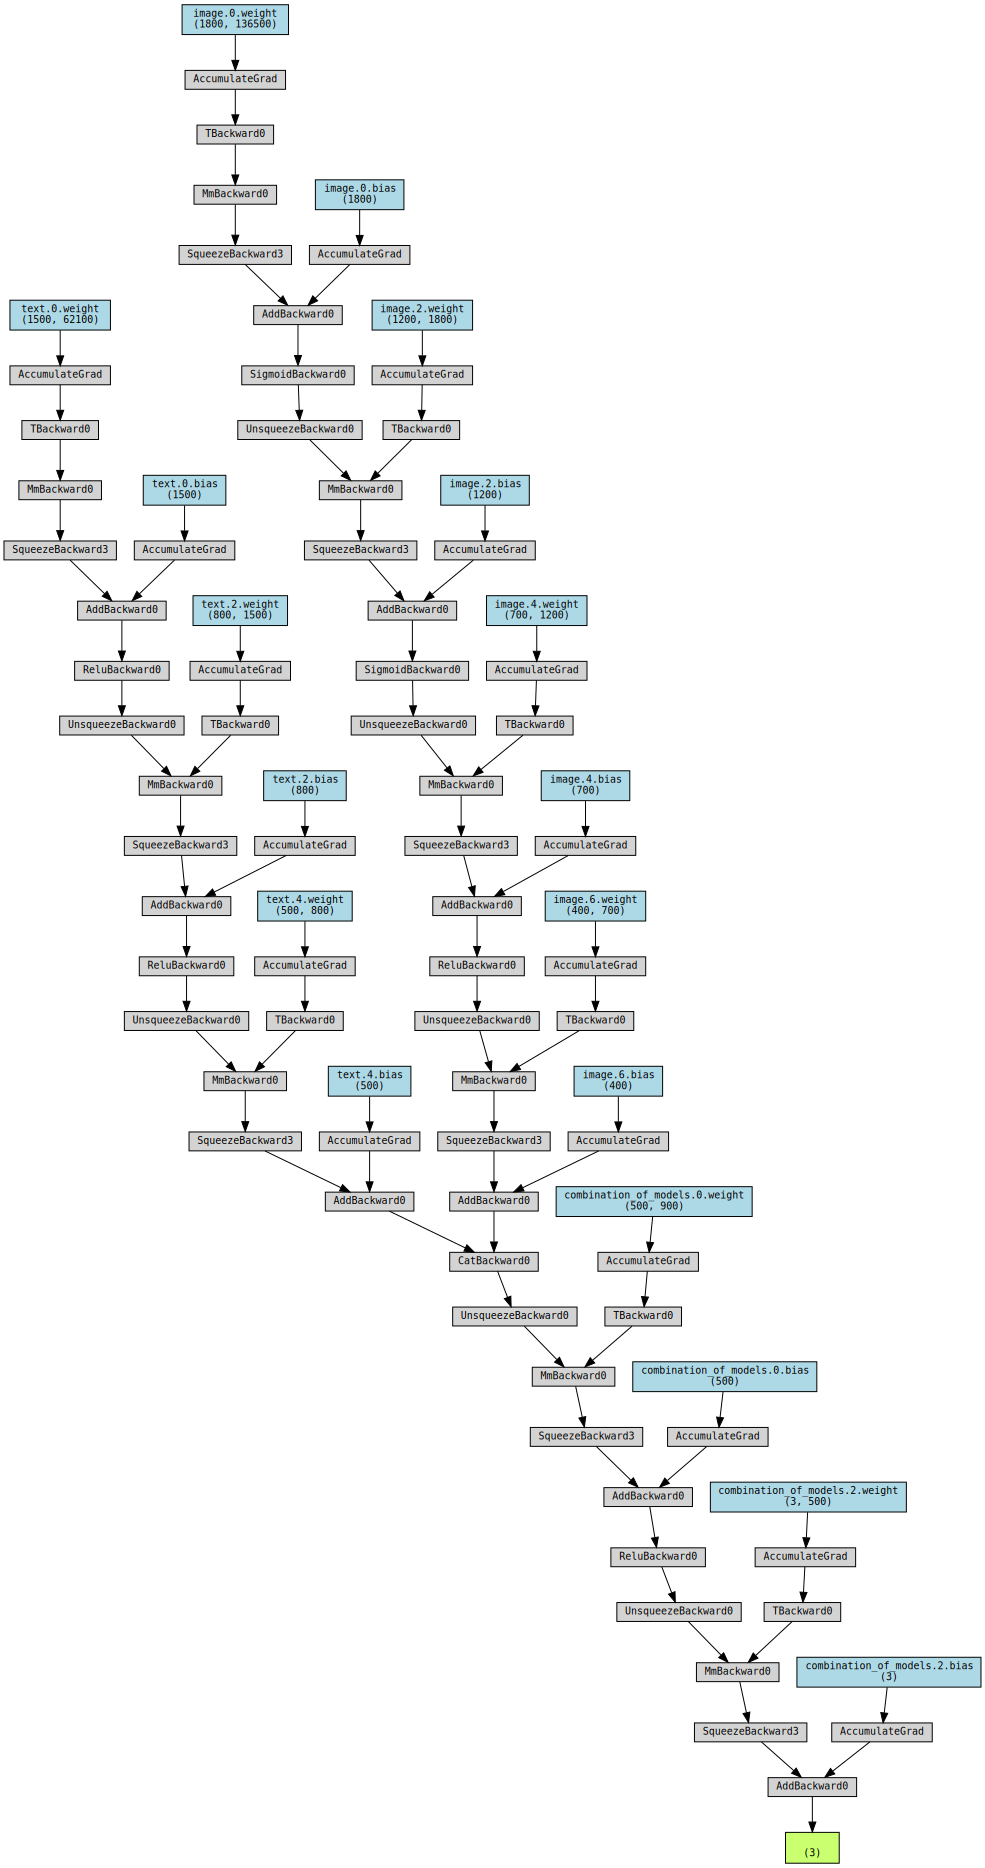

In [13]:
images=np.array(X_train["image_name"])
os.chdir(featured_path)
feature,label= image_features(images[0])
feature=torch.tensor(feature)
t_feature=text_features(images[0])
t_feature= torch.tensor(t_feature)
make_dot(neural_network(t_feature.cuda().float(),feature.cuda().float()), params=dict(neural_network.named_parameters()))

# Saving the Model

In [14]:
model_path="/content/drive/MyDrive/Project_AI"+"/model2.pth"


In [15]:
torch.save(neural_network.state_dict(), model_path)

# Loading Model

In [16]:
multimodel = Multi_Model_NN(textinput,imginputneurons,texthidden1,texthidden2,comh1,imghidden1,imghidden2,output,imghidden3,texthidden3,imghidden4).cuda()   
multimodel.load_state_dict(torch.load(model_path))
multimodel.eval()

Multi_Model_NN(
  (text): Sequential(
    (0): Linear(in_features=62100, out_features=1500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1500, out_features=800, bias=True)
    (3): ReLU()
    (4): Linear(in_features=800, out_features=500, bias=True)
  )
  (image): Sequential(
    (0): Linear(in_features=136500, out_features=1800, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=1800, out_features=1200, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=1200, out_features=700, bias=True)
    (5): ReLU()
    (6): Linear(in_features=700, out_features=400, bias=True)
  )
  (combination_of_models): Sequential(
    (0): Linear(in_features=900, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=3, bias=True)
  )
)

# Testing data

In [30]:
X_test

,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational
10042,image_2813_rotated180.jpeg,WHAT IF I TOLD YOU THE RED DOT IS CONTROLLED B...,WHAT IF I TOLD YOU THE RED DOT IS CONTROLLED B...,funny,very_twisted,not_offensive,motivational
11649,image_6474_flipLR.jpeg,Who Would Win? A German artist with little art...,Who Would Win? A German artist with little art...,funny,general,slight,motivational
12069,image_4169_flipTB.jpeg,YOUR FACE WHEN YOU REALIZE TI FAT GUY IN TITAN...,YOUR FACE WHEN YOU REALIZE TI FAT GUY IN TITAN...,very_funny,general,very_offensive,not_motivational
6570,image_6584.jpg,Anti-vaxx kid getting nervous on his third bir...,Anti-vaxx kid getting nervous on his third bir...,funny,general,slight,not_motivational
1924,image_1926.png,MISS COLOMBIA WAS LIKE @STANGYOASS SO,MISS COLOMBIA WAS LIKE @STANGYOASS SO DID AND...,very_funny,general,not_offensive,motivational
...,...,...,...,...,...,...,...
1488,image_1490.jpg,"BEYONCÉ HAS BEEN “CRAZY IN LOVE"" ""DANGEROUSLY ...","BEYONCÉ HAS BEEN “CRAZY IN LOVE"" ""DANGEROUSLY ...",not_funny,general,slight,not_motivational
3640,image_3648.png,RUSSIA IS SO SEXIST THEY DON'T WANT TO BE NUKE...,RUSSIA IS SO SEXIST THEY DON'T WANT TO BE NUKE...,funny,twisted_meaning,slight,motivational
1833,image_1835.png,Anything else? Yeah,Anything else? Yeah stay away from me! Alrigh...,very_funny,general,slight,not_motivational
9382,image_2444_rotated90.jpeg,"When the butter says ""spreadable"" but you rip ...","When the butter says ""spreadable"" but you rip ...",hilarious,twisted_meaning,hateful_offensive,not_motivational


In [31]:
os.chdir(featured_path)
images=np.array(X_test["image_name"])
list1=[]
actual_label=[]

for i in range(0,len(images)):
    feature,label= image_features(images[i])
    actual_label.append(label)
    t_feature=text_features(images[i])
    t_feature=torch.tensor(t_feature)
    featuret=torch.tensor(feature)
    label=torch.tensor(label)
    y_pred = neural_network(t_feature.cuda().float(),featuret.cuda().float())
    list1.append(torch.argmax(y_pred).cpu().detach().numpy())
  
   

# Accuracy and F1Score

In [33]:
from sklearn.metrics import f1_score,accuracy_score
print("F1Score: ",f1_score(y_test,list1,average='macro')*100)
print("Accuracy: ",accuracy_score(y_test,list1)*100)


F1Score:  65.49258565782324
Accuracy:  69.73751930005146
